In [2]:
import pandas as pd
from sklearn import preprocessing, neighbors
from scipy.spatial import distance
import numpy as np
import  matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity, laplacian_kernel
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from scipy.linalg import sqrtm, inv

import seaborn as sns

In [3]:
df = pd.read_csv('/content/Payments.csv')

df

Sender  Receiver  Amount
0         1309      1011  123051
1         1309      1011  118406
2         1309      1011  112456
3         1309      1011  120593
4         1309      1011  166396
...        ...       ...     ...
130530    1344      1390   21739
130531    1914      1390    3374
130532    1914      1390    5186
130533    1914      1390    1559
130534    1914      1390    1997

[130535 rows x 3 columns]

In [4]:
df.max() - df.min()

Sender         1189
Receiver        886
Amount      2122999
dtype: int64

In [5]:
data = df.to_numpy()

## Step 1: Preprocessing dataset

In [6]:
data = preprocessing.normalize(data)
data.shape

(130535, 3)

## Step 2: Compute similarity matrix/ Adjacency matrix, degree matrix and laplacian matrix

In [7]:
import networkx as nx
import pandas as pd
edge_list = pd.read_csv(r'/content/Payments.csv')
edge_list.head()
edge_list = edge_list.applymap(str)
G=nx.from_pandas_edgelist(edge_list, source='Sender', target='Receiver', edge_attr=True, create_using=nx.DiGraph())
G.nodes

NodeView(('1309', '1011', '1259', '1568', '1147', '1393', '1039', '1210', '1005', '1042', '1045', '1018', '1256', '1074', '1668', '1163', '1007', '1034', '1832', '1099', '1488', '1801', '1076', '1944', '1659', '1048', '1205', '1057', '1220', '1032', '1837', '1061', '1222', '1017', '1075', '1023', '2085', '1503', '2088', '1350', '1327', '1276', '1666', '1056', '1748', '1658', '1003', '1228', '1138', '1089', '1002', '1623', '1264', '1875', '1004', '1595', '1090', '1051', '1101', '1079', '1104', '1839', '1747', '1135', '1656', '1500', '1148', '1136', '1172', '1132', '1809', '1774', '1037', '1930', '2184', '1243', '1293', '1990', '1690', '1449', '1310', '1679', '1159', '1335', '1862', '1049', '1105', '1766', '1013', '1541', '1961', '1575', '1189', '1723', '1962', '1084', '1480', '2146', '1405', '1016', '1729', '2166', '2073', '1015', '1344', '1917', '1535', '1077', '1087', '1431', '1080', '1098', '1701', '1009', '1191', '1142', '1081', '1146', '1199', '1754', '1545', '1134', '1517', '1202'

In [8]:
# function to generate random walk sequences of nodes for a particular node
def get_random_walk(node, walk_length):
    # initialization
    random_walk_length = [node]

    #loop over to get the nodes visited in a random walk
    for i in range(walk_length-1):
        # list of neighbors
        neighbors = list(G.neighbors(node))
        # if the same neighbors are present in ranom_walk_length list, then donot add them as new neighbors
        neighbors = list(set(neighbors) - set(random_walk_length))
        if len(neighbors) == 0:
            break
        # pick any one neighbor randomly from the neighbors list
        random_neighbor = random.choice(neighbors)
        # append that random_neighbor to the random_walk_length list
        random_walk_length.append(random_neighbor)
        node = random_neighbor

    return random_walk_length

In [9]:
import random  # Import the random module

def get_random_walk(node, walk_length):
    random_walk_length = [node]  # Initialize the random walk list with the starting node
    while len(random_walk_length) < walk_length:  # Continue until desired walk length is achieved
        # Get the neighbors of the current node
        neighbors = list(G.neighbors(random_walk_length[-1]))
        if len(neighbors) == 0:
            break
        # Pick any one neighbor randomly from the neighbors list
        random_neighbor = random.choice(neighbors)
        # Append that random_neighbor to the random_walk_length list
        random_walk_length.append(random_neighbor)
    return random_walk_length

# Now you can call the get_random_walk function
get_random_walk('1838', 10)


['1838', '1517', '1246', '1084', '1011', '1523', '1836']

In [10]:
get_random_walk('1838', 10)
# calculate random walks for every node in the Graph
all_nodes = list(G.nodes())
number_of_random_walks = 5
random_walks = []
from tqdm import tqdm

for node in tqdm(all_nodes):
    # number of random walks
    for i in range(number_of_random_walks):
        # append the random walk sequence of a node from a specified length
        random_walks.append(get_random_walk(node, 10))
        len(random_walks)
        random_walks[0]
        # train word2vec model
        from gensim.models import Word2Vec
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
    )

model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)
# most similar nodes to node '1517'
for node, _ in model.wv.most_similar('1517'):
    print((node, _))

100%|██████████| 799/799 [00:00<00:00, 985.52it/s]


('1838', 0.8100499510765076)
('1633', 0.7212695479393005)
('1236', 0.7091253995895386)
('1124', 0.6847909092903137)
('1824', 0.6824749112129211)
('1428', 0.6643710732460022)
('1238', 0.6604845523834229)
('1441', 0.6490654349327087)
('1837', 0.6389124989509583)
('1786', 0.635977029800415)


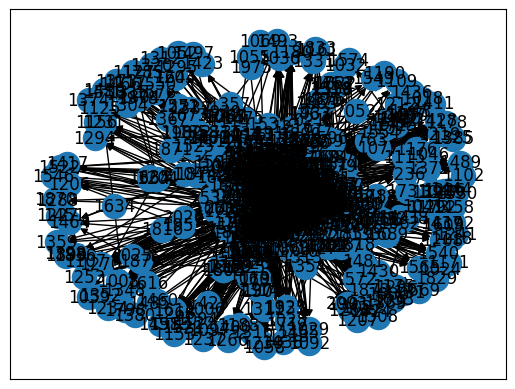

In [11]:
nx.draw_networkx(G)

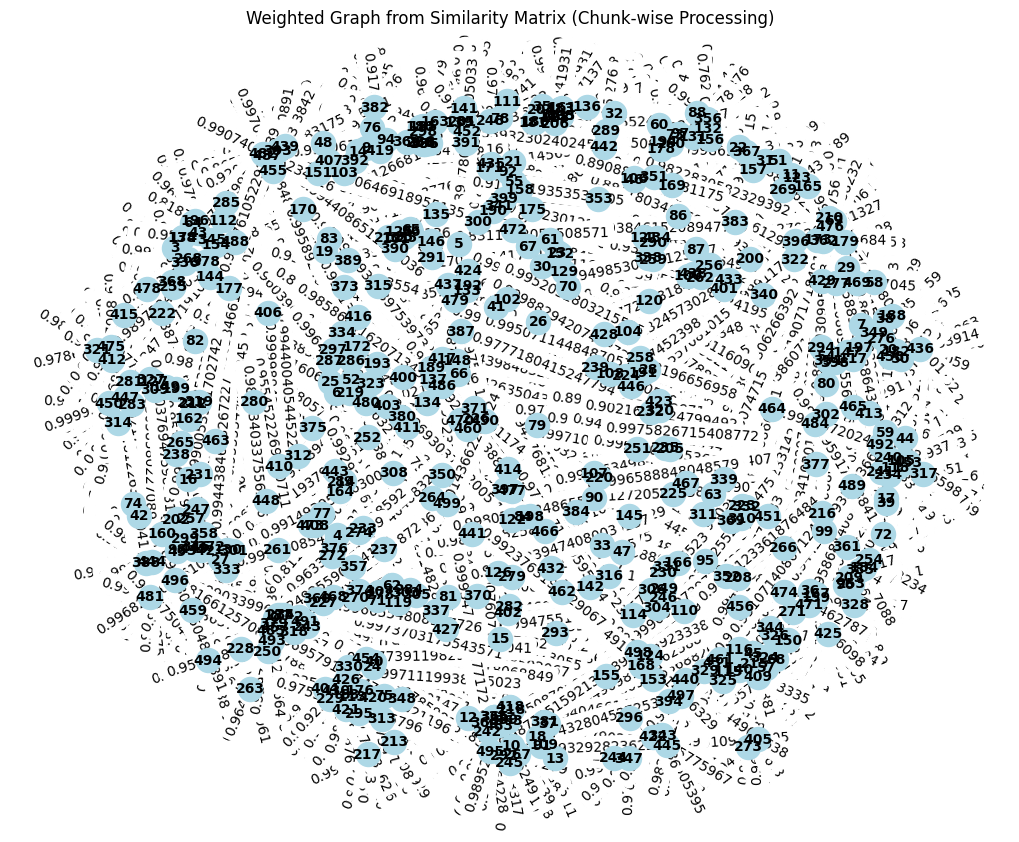

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import rbf_kernel
import networkx as nx

# Load data from CSV file
chunk_size = 500  # Adjust the chunk size based on available memory
reader = pd.read_csv('/content/Payments.csv', chunksize=chunk_size)

# Initialize an empty weighted graph
G = nx.Graph()

for chunk in reader:
    # Preprocess the chunk
    data = chunk.to_numpy()
    data = normalize(data)

    # Compute similarity matrix using RBF kernel
    similarity_matrix = rbf_kernel(data)

    # Add edges to the graph from the similarity matrix
    num_nodes = similarity_matrix.shape[0]
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            weight = similarity_matrix[i, j]
            if weight > 0:
                G.add_edge(i, j, weight=weight)

# Optionally, you can visualize the weighted graph
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Layout the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=300, font_size=10, font_weight='bold', width=0.5)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Weighted Graph from Similarity Matrix (Chunk-wise Processing)")
plt.show()


In [3]:
similarity_matrix

array([[1.        , 0.90154063, 0.94304423, ..., 0.99611296, 0.86639992,
        0.90640259],
       [0.90154063, 1.        , 0.99326099, ..., 0.93388152, 0.99646186,
        0.99992249],
       [0.94304423, 0.99326099, 1.        , ..., 0.96784392, 0.98017561,
        0.99462017],
       ...,
       [0.99611296, 0.93388152, 0.96784392, ..., 1.        , 0.90313898,
        0.93801459],
       [0.86639992, 0.99646186, 0.98017561, ..., 0.90313898, 1.        ,
        0.9953425 ],
       [0.90640259, 0.99992249, 0.99462017, ..., 0.93801459, 0.9953425 ,
        1.        ]])

### P. Yang et. al. (***'A Spectral Clustering Algorithm for Outlier Detection'***) suggests a methodology to reduce the computation time complexity by making the adjacency matrix sparse by limiting the number of neighborhoods to a set of nodes with high similarity values by using a threshold to neglect low similarity neighborhoods. This threshold according to the paper lies in the interval;

### <center>[$\mu$ - $\sigma$, $\mu$)</center>


### This will help in isolating outliers and constuct a sparse matrix

In [4]:
# Computing mean and std dev for deciding threshold value.

mean = np.mean(similarity_matrix)
std_dev = np.std(similarity_matrix)

threshold_range = (mean-std_dev, mean)
threshold_range

(0.9195155950181347, 0.9627999143166521)

In [5]:
# Defining threshold and computing discretized adjacency matrix

threshold = 0.9

adj_matrix = np.zeros((similarity_matrix.shape[0], similarity_matrix.shape[1]))

for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        if i == j:
            adj_matrix[i][j] = 0
        else:
            adj_matrix[i][j] = 1 if similarity_matrix[i][j] >= threshold else 0

In [6]:
# Display dicretized Adjacency matrix

adj_matrix

array([[0., 1., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [0., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [7]:
G = nx.Graph(adj_matrix)

In [8]:
G.number_of_edges()

530

In [9]:
# Computing degree matrix

deg_matrix = np.diag(np.sum(adj_matrix, axis=1))

deg_matrix

array([[33.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 27.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 30., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 34.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 23.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 28.]])

In [12]:
# Computing normalised Laplacian matrix
from scipy.linalg import sqrtm
from numpy.linalg import inv

I = np.identity(len(adj_matrix))

norm_laplacian = I - ((sqrtm(inv(deg_matrix))).dot(adj_matrix)).dot(sqrtm(inv(deg_matrix)))

In [13]:
# Chechking whether the Laplacian matrix is hermitian.

np.all(norm_laplacian) == np.all(norm_laplacian.T)

True

### Step 3: Compute eigen values and eigen vectors of laplacian matrix

In [15]:
# Computing eigen values and vectors
from scipy.sparse.linalg import eigsh

eigen_values, eigen_vectors = eigsh(norm_laplacian, k=15, which='SM')      # Parameter 'SM' indicated smallest magnitue of eigen values
eigen_vectors = np.round(eigen_vectors[:, np.argsort(eigen_values)], 6)
eigen_values = np.round(np.abs(eigen_values[np.argsort(eigen_values)]), 6)


In [16]:
# Displaying first 15 Eigen values

eigen_values

array([0.      , 0.75364 , 0.957511, 0.982365, 0.989379, 1.011916,
       1.01308 , 1.029412, 1.029412, 1.029412, 1.029412, 1.029412,
       1.029412, 1.030303, 1.030303])

Text(0, 0.5, 'Eigen values')

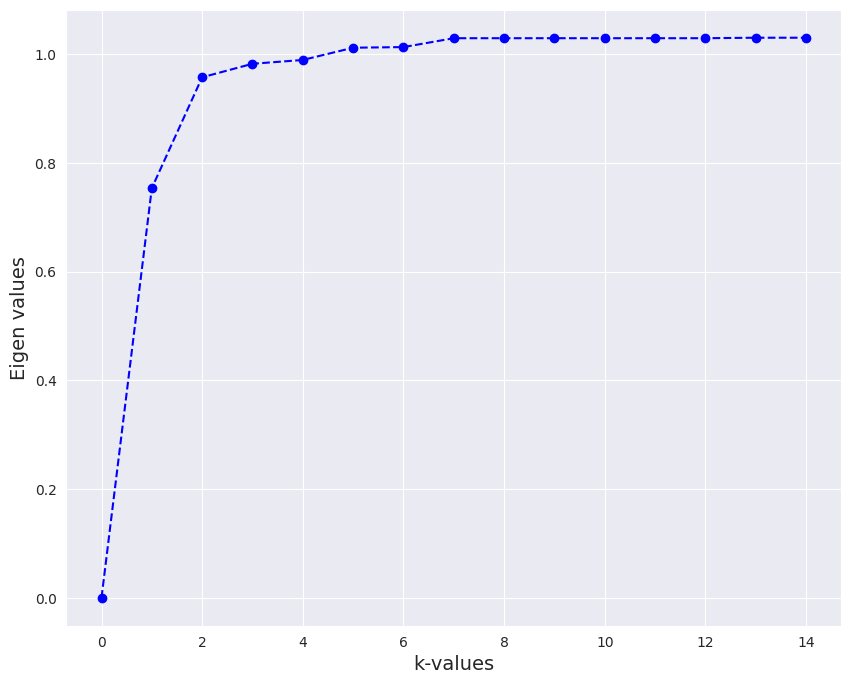

In [18]:
# Plotting elbow points
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set_style("darkgrid")

plt.plot(eigen_values, color='b', marker='o', linestyle='--')
plt.xlabel('k-values', fontsize=14)
plt.ylabel('Eigen values', fontsize=14)

### It can be observed from above plot that the first large spectral gap occurs after two points indicating that there exists two clusters in the dataset. This heuristic analysis is confirmed below by computing Mean Square error for different number of clusters. The no. of clusters resulting in lowest MSE is chosen to be the optimum number of clusters.

#

In [20]:
# Computing Mean Square Error and finding evidence for optimum no. of clusters
from sklearn.cluster import KMeans

cluster_counts = {}
MSE = {}

cluster_hyperparam = [2, 3, 4, 5, 6, 7]

for clusters in cluster_hyperparam:
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(eigen_vectors[:, 1:clusters])

    cluster_labels = kmeans.labels_
    unique, counts = np.unique(cluster_labels, return_counts=True)
    cluster_counts[f"Count dict for {clusters} clusters"] = dict(zip(unique, counts))

    MSE[f"For {clusters} clusters"] = np.round(kmeans.inertia_, 6)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [21]:
pd.DataFrame(cluster_counts).fillna(0)

Count dict for 2 clusters  Count dict for 3 clusters  \
0                       21.0                        4.0   
1                       14.0                       16.0   
2                        0.0                       15.0   
3                        0.0                        0.0   
4                        0.0                        0.0   
5                        0.0                        0.0   
6                        0.0                        0.0   

   Count dict for 4 clusters  Count dict for 5 clusters  \
0                        2.0                        1.0   
1                       16.0                        6.0   
2                        5.0                       11.0   
3                       12.0                       12.0   
4                        0.0                        5.0   
5                        0.0                        0.0   
6                        0.0                        0.0   

   Count dict for 6 clusters  Count dict for 7 clusters  
0                        5.0                          9  
1                       12.0                         11  
2                        5.0                          4  
3                        9.0                          2  
4                        2.0                          5  
5                        2.0                          2  
6                        0.0                          2

In [22]:
MSE

{'For 2 clusters': 0.34401,
 'For 3 clusters': 0.703881,
 'For 4 clusters': 1.084315,
 'For 5 clusters': 1.197442,
 'For 6 clusters': 1.424297,
 'For 7 clusters': 1.635034}

In [23]:
print(f"Minimum MSE value obtained {min(MSE, key=MSE.get)}")

Minimum MSE value obtained For 2 clusters


### Thus we have obtained evidence for our heuristic analysis of the optimum no. of clusters to be 2. From above result we can see that the max no. of datapoints (1197) belong to cluster 0 while only two datapoints belong to cluster 1. Thus it is highly likely that these two datapoints are outliers.